<a href="https://colab.research.google.com/github/Coralain10/ML_Archaeological-Objects-Reconstruction/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!wget https://github.com/Coralain10/ML_Archaeological-Objects-Reconstruction/blob/main/data/FullAndFracture.zip

In [ ]:
!unzip /content/FullAndFracture.zip

In [2]:
data = np.load('FullAndFracture.npy')

In [35]:
!rm FullAndFracture.zip

In [3]:
data.shape #completo|fracturado, modelos, objeto

(2, 7112, 32, 32, 32)

In [4]:
X = data[1] #fracturado
Y = data[0] #completo

In [5]:
def bbvox_points(obj):
  points = []
  for z in range(32):
    for y in range(32):
      for x in range(32):
        if obj[x,y,z]:
          points += [ (x,y,z) ]
  return np.array(points)

def showArr3DC(points, pos=1):
  # plt.subplots(figsize=(6,6))
  ax = plt.subplot(1, 3, pos, projection='3d' )
  ax.scatter3D(points[:,0], points[:,1], points[:,2], c='black')

def showArr3DBoolC(obj, pos=1):
  showArr3DC( bbvox_points(obj), pos )

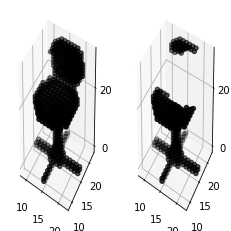

In [7]:
#@title Visualizar {run: "auto"}
id = 283 #@param {type: 'slider', max:888, min:0, step:1}
showArr3DBoolC(Y[id], 1) #completo
showArr3DBoolC(X[id], 2) #fracturado

# DCGAN3D - Pytorch

In [6]:
import torch
from torch import nn, optim
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, TensorDataset #, Dataset
# from torchvision.transforms import ToTensor
# from torch.autograd import Variable

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [7]:
torch.manual_seed(0)

In [8]:
def show_tensor_images(image_tensor, size, pos, num_images=9):
  image_unflat = image_tensor.detach().cpu().view(-1, *size)
  image_grid = make_grid(image_unflat[:num_images], nrow=3)
  showArr3DBoolC( image_grid, pos ) #.permute(1, 2, 0).squeeze()

In [9]:
#@title Bloque de Convolucion 
class ConvBlock(nn.Module):
  """(convolution => [BN] => ReLU) * 2"""

  def __init__(self, in_channels, out_channels, mid_channels=None):
    super().__init__()
    # if not mid_channels:
    mid_channels = out_channels
    self.double_conv = nn.Sequential(
      nn.Conv3d(in_channels, mid_channels, kernel_size=3, padding='same'),
      nn.BatchNorm3d(mid_channels),
      nn.ReLU(inplace=True),
      # nn.Conv3d(mid_channels, out_channels, kernel_size=3, padding='same'),
      # nn.BatchNorm3d(out_channels),
      # nn.ReLU(inplace=True)
    )
  
  def forward(self, x):
    # print('3DConv Ok')
    return self.double_conv(x)

In [10]:
#@title Discriminador (Encoder)
class Discriminator(nn.Module):
  """Downscaling """
  
  class Down(nn.Module):
    """[Block] Downscaling with AvgPool then double conv"""
    def __init__(self, in_channels, out_channels):
      super().__init__()
      self.maxpool_conv = nn.Sequential(
        nn.AvgPool3d(kernel_size = 2), # nn.MaxPool2d(2)
        ConvBlock(in_channels, out_channels)
      )
    def forward(self, x):
      return self.maxpool_conv(x)

  def __init__(self, trilinear=True):
    super(Discriminator, self).__init__()
    self.inc = ConvBlock(1, 32)      #32^3
    self.down1 = self.Down(32, 64)    #16^3
    self.down2 = self.Down(64, 128)   #8^3
    self.down3 = self.Down(128, 256)  #4^3
    self.factor = 2 if trilinear else 1
    self.down4 = self.Down(256, 512 // self.factor)

  def forward(self, x):
    x = self.inc(x)
    x = self.down1(x)
    x = self.down2(x)
    x = self.down3(x)
    x = self.down4(x)
    # print('Encoder Ok', x.shape)
    return x

In [11]:
#@title Generador (UNet)
class Generator(Discriminator):
  """Upscaling"""
  
  class Up(nn.Module):
    """[Block] Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, trilinear=True):
      super().__init__()
      # if trilinear, use the normal convolutions to reduce the number of channels
      if trilinear:
        self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        self.conv = ConvBlock(in_channels, out_channels, in_channels // 2)
      else:
        self.up = nn.ConvTranspose3d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_channels, out_channels)
    def forward(self, x1, x2):
      x1 = self.up(x1)
      # input is CHW
      diffY = x2.size()[2] - x1.size()[2]
      diffX = x2.size()[3] - x1.size()[3]
      x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                      diffY // 2, diffY - diffY // 2])
      x = torch.cat([x2, x1], dim=1)
      return self.conv(x)
    
  def __init__(self, trilinear=True):
    super(Generator, self).__init__(trilinear)
    self.up1 = self.Up(512, 256 // self.factor, trilinear)
    self.up2 = self.Up(256, 128 // self.factor, trilinear)
    self.up3 = self.Up(128, 64 // self.factor, trilinear)
    self.up4 = self.Up(64, 32, trilinear)
    self.outc = ConvBlock(32, 1)

  def forward(self, x):
    # print('inicial x',x.shape)
    x1 = self.inc(x)
    # print('down x1',x1.shape)
    x2 = self.down1(x1)
    # print('down x2',x2.shape)
    x3 = self.down2(x2)
    # print('down x3',x3.shape)
    x4 = self.down3(x3)
    # print('down x4',x4.shape)
    x5 = self.down4(x4)
    # print('down x5',x5.shape)
    x = self.up1(x5, x4)
    # print('up x1',x.shape)
    x = self.up2(x, x3)
    # print('up x2',x.shape)
    x = self.up3(x, x2)
    # print('up x3',x.shape)
    x = self.up4(x, x1)
    # print('up x4',x.shape)
    logits = self.outc(x)
    # print('up x5',logits.shape)
    # print('UNet Ok')
    return logits

### Funciones de Pérdida

In [12]:
def get_gen_loss(gen, disc, criterion, incomplete, num_images, device):
  fake = gen(incomplete)
  disc_fake_pred = disc(fake)
  gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
  return gen_loss

In [13]:
def get_disc_loss(gen, disc, criterion, incomplete, complete, num_images, device):
  fake = gen(incomplete)
  disc_fake_pred = disc(fake.detach())
  disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
  disc_real_pred = disc(complete)
  disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
  disc_loss = (disc_fake_loss + disc_real_loss) / 2
  return disc_loss

## Guardar modelo

In [14]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [15]:
drive_folder = '/gdrive/MyDrive/UPC-CC/6. Machine Learning/'

In [16]:
def save_model(n):
  torch.save(disc.state_dict(), f'{drive_folder}disc_{n}.pth')
  torch.save(gen.state_dict(), f'{drive_folder}gen_{n}.pth')
  print(f'disc_{n}.pth and gen_{n}.pth were saved.')

## Configuraciones

**Dataset**

In [17]:
size = (32,32,32)
# z_dim = 1
# hidden_dim = 32
# im_dim = 32**3
# shape (7112, 32, 32, 32)
#shape must be [num_objs, n_channels, depth,height,width]
X = X.reshape( X.shape[0], 1, *size )
Y = Y.reshape( Y.shape[0], 1, *size )

In [18]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.7)

In [19]:
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

In [20]:
train_data = TensorDataset(x_train, y_train) #CustomDataset
test_data = TensorDataset(x_test, y_test) #CustomDataset

In [21]:
n_epochs = 200
save_epoch = 8 #@param {type:'slider', min:1, max:200, step:1}
display_step = 500 #@param {type:'slider', min:500, max:1000, step:1}
batch_size = 128
lr = 0.00001

In [22]:
criterion = nn.BCEWithLogitsLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [23]:
gen = Generator().to(device) #z_dim, hidden_dim, im_dim
# gen_opt = optim.Adam(gen.parameters(), lr=lr)
gen_opt = optim.RMSprop(gen.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
disc = Discriminator().to(device) #im_dim, hidden_dim
# disc_opt = optim.Adam(disc.parameters(), lr=lr)
disc_opt = optim.RMSprop(disc.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)

## Entrenamiento

In [24]:
def train(last_step=0, last_epoch=0):
  cur_step = last_step
  mean_generator_loss = 0
  mean_discriminator_loss = 0
  gen_loss = False
  error = False

  for epoch in range(last_epoch,n_epochs):
    for incomplete, complete in tqdm(dataloader):
      cur_batch_size = len(complete)
      # complete = Variable(complete)
      # incomplete = Variable(incomplete)
      # complete = complete.view(cur_batch_size, -1).to(device)
      # incomplete = incomplete.view(cur_batch_size, -1).to(device)
      complete = complete.to(device=device, dtype=torch.float32)
      incomplete = incomplete.to(device=device, dtype=torch.float32)
      #Loss
      disc_opt.zero_grad()
      disc_loss = get_disc_loss(gen, disc, criterion, incomplete, complete, cur_batch_size, device)
      disc_loss.backward(retain_graph=True)
      disc_opt.step()
      gen_opt.zero_grad()
      gen_loss = get_gen_loss(gen, disc, criterion, incomplete, cur_batch_size, device)
      gen_loss.backward()
      gen_opt.step()
      mean_discriminator_loss += disc_loss.item() / display_step
      mean_generator_loss += gen_loss.item() / display_step

      #Display
      if cur_step % display_step == 0 and cur_step > 0:
        print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
        fake = gen(incomplete)
        show_tensor_images(incomplete, size, 1)
        show_tensor_images(fake, size, 2)
        show_tensor_images(complete, size, 3)
        mean_generator_loss = 0
        mean_discriminator_loss = 0
      cur_step += 1
    
    #Save
    if epoch % save_epoch == 0 and epoch > 0:
      save_model(epoch//save_epoch)
      print(f'Epoch: {epoch} / {n_epochs}')

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

disc_1.pth and gen_1.pth were saved.
Epoch: 4 / 200


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Step 500: Generator loss: 0.5628770821094514, discriminator loss: 0.7074059160947797


KeyboardInterrupt: ignored

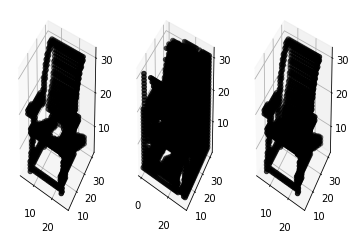

In [25]:
train(last_step=0, last_epoch=0)

# Testing

In [ ]:
!wget https://github.com/Coralain10/ML_Archaeological-Objects-Reconstruction/blob/main/data/broken_chair.npy?raw=true -O broken_chair.npy

--2022-11-18 06:31:10--  https://github.com/Coralain10/ML_Archaeological-Objects-Reconstruction/blob/main/data/broken_chair.npy?raw=true
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Coralain10/ML_Archaeological-Objects-Reconstruction/raw/main/data/broken_chair.npy [following]
--2022-11-18 06:31:10--  https://github.com/Coralain10/ML_Archaeological-Objects-Reconstruction/raw/main/data/broken_chair.npy
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Coralain10/ML_Archaeological-Objects-Reconstruction/main/data/broken_chair.npy [following]
--2022-11-18 06:31:10--  https://raw.githubusercontent.com/Coralain10/ML_Archaeological-Objects-Reconstruction/main/data/broken_chair.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.1

In [ ]:
filename = 'broken_chair.npy' #@param {type:'string'}
array = np.load(filename)